Dataset loaded for Phase 3!
Shape: (1000, 9)
Training Samples: 750
Testing Samples:  250
 Training Ensemble Model...

 Ensemble Model Performance (Stacking Regressor):
MAE:  79.0586
RMSE: 114.2183
R²:   0.9295


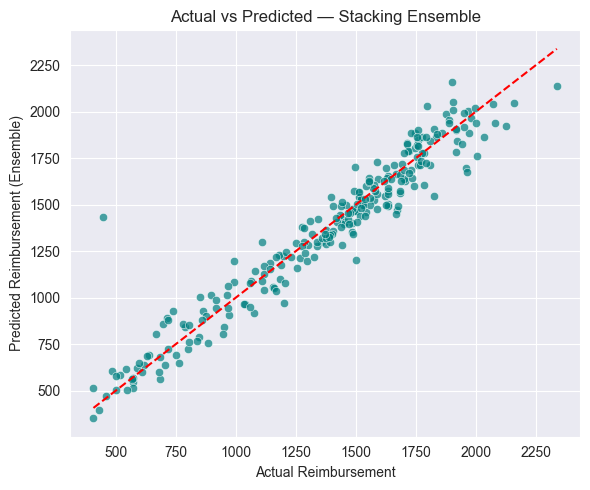


 FINAL MODEL SAVED: final_model.pkl
 Predictions saved to phase3_predictions.csv

===== 🔎 Fit Diagnostics (Train vs Test) =====
TRAIN -> MAE: 47.44 | RMSE: 71.92 | R²: 0.9778 | ≤$1: 0.019 | ≤$5: 0.073
TEST  -> MAE: 79.06 | RMSE: 114.22 | R²: 0.9295 | ≤$1: 0.004 | ≤$5: 0.028

----- Generalization Gaps (Train - Test) -----
MAE gap:  -31.62
RMSE gap: -42.30
R² gap:   0.0483
≤$1 gap:  0.015
≤$5 gap:  0.045

 Likely OVERFITTING: train is much better than test.


In [1]:
# ==========================================================
# Phase 3 – Ensemble Learning (Stacking Regressor)
# ==========================================================

from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import pandas as pd
import numpy as np
import joblib

# Load the enhanced dataset from Phase 2
combined_df = pd.read_csv("phase2_features_baseline_models.csv")

print("Dataset loaded for Phase 3!")
print("Shape:", combined_df.shape)

# ---------------------------------------
# Select Features and Target
# ---------------------------------------
features = [
    "trip_duration_days",
    "miles_traveled",
    "total_receipts_amount",
    "cost_per_day",
    "cost_per_mile",
    "miles_per_day",
    "cost_ratio"
]

target = "reimbursement"

X = combined_df[features]
y = combined_df[target]

# ---------------------------------------
# Manual 75/25 split
# ---------------------------------------
split = int(0.75 * len(combined_df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples:  {len(X_test)}")
print(" Training Ensemble Model...")

# ----------------------------------------------------------
# Define Base Models
# ----------------------------------------------------------
base_models = [
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('random_forest', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42))
]

# ----------------------------------------------------------
# Meta-Learner (Final model that blends predictions)
# ----------------------------------------------------------
meta_model = LinearRegression()

# ----------------------------------------------------------
# Build Stacking Regressor
# ----------------------------------------------------------
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # includes original features + model predictions
)

# Train Stacking Ensemble
stack_model.fit(X_train, y_train)

# ----------------------------------------------------------
# Evaluate Model
# ----------------------------------------------------------
stack_pred = stack_model.predict(X_test)

mae = mean_absolute_error(y_test, stack_pred)
rmse = sqrt(mean_squared_error(y_test, stack_pred))
r2 = r2_score(y_test, stack_pred)

print("\n Ensemble Model Performance (Stacking Regressor):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# ----------------------------------------------------------
# Plot Actual vs Predicted
# ----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=stack_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Reimbursement")
plt.ylabel("Predicted Reimbursement (Ensemble)")
plt.title("Actual vs Predicted — Stacking Ensemble")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Save Final Production Model
# ----------------------------------------------------------
joblib.dump(stack_model, "final_model.pkl")
print("\n FINAL MODEL SAVED: final_model.pkl")

# ----------------------------------------------------------
# OPTIONAL: Save predictions for report
# ----------------------------------------------------------
output_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": stack_pred
})
output_df.to_csv("phase3_predictions.csv", index=False)

print(" Predictions saved to phase3_predictions.csv")


#Checking the results of this model
def match_rates(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    abs_diff = np.abs(y_pred - y_true)
    return {
        "exact_<=0.01": float((abs_diff <= 0.01).mean()),
        "close_<=1.00": float((abs_diff <= 1.00).mean()),
        "within_<=5.00": float((abs_diff <= 5.00).mean()),
    }

def regression_metrics(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(sqrt(mean_squared_error(y_true, y_pred))),
        "R2": float(r2_score(y_true, y_pred)),
    }

# --- Train predictions (for fit checking)
train_pred = stack_model.predict(X_train)

train_m = regression_metrics(y_train, train_pred)
test_m  = regression_metrics(y_test, stack_pred)

train_r = match_rates(y_train, train_pred)
test_r  = match_rates(y_test, stack_pred)

print("\n=====  Fit Diagnostics (Train vs Test) =====")
print(f"TRAIN -> MAE: {train_m['MAE']:.2f} | RMSE: {train_m['RMSE']:.2f} | R²: {train_m['R2']:.4f} "
      f"| ≤$1: {train_r['close_<=1.00']:.3f} | ≤$5: {train_r['within_<=5.00']:.3f}")

print(f"TEST  -> MAE: {test_m['MAE']:.2f} | RMSE: {test_m['RMSE']:.2f} | R²: {test_m['R2']:.4f} "
      f"| ≤$1: {test_r['close_<=1.00']:.3f} | ≤$5: {test_r['within_<=5.00']:.3f}")

# Generalization gaps (train - test)
print("\n----- Generalization Gaps (Train - Test) -----")
print(f"MAE gap:  {train_m['MAE'] - test_m['MAE']:.2f}")
print(f"RMSE gap: {train_m['RMSE'] - test_m['RMSE']:.2f}")
print(f"R² gap:   {train_m['R2'] - test_m['R2']:.4f}")
print(f"≤$1 gap:  {train_r['close_<=1.00'] - test_r['close_<=1.00']:.3f}")
print(f"≤$5 gap:  {train_r['within_<=5.00'] - test_r['within_<=5.00']:.3f}")

# Simple interpretation flags
if (train_m["MAE"] + 15) < test_m["MAE"] or (train_m["R2"] - test_m["R2"]) > 0.03:
    print("\n Likely OVERFITTING: train is much better than test.")
elif (train_m["MAE"] > 80 and test_m["MAE"] > 80) and (train_m["R2"] < 0.90 and test_m["R2"] < 0.90):
    print("\n Likely UNDERFITTING: both train and test errors are high.")
else:
    print("\n No strong over/underfitting signal from these thresholds.")
